<a href="https://colab.research.google.com/github/mherbsom/AAE590/blob/main/Homework_2_590.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Max Stress


MAE: 0.875
Config: 43.900000000000006
=== LASSO Regression ===
Coefficients: [ -0.         501.74378305  -0.          -0.        ]
Intercept: 860.766129032258
R^2 on Test: 0.885
MSE on Test: 40682.056



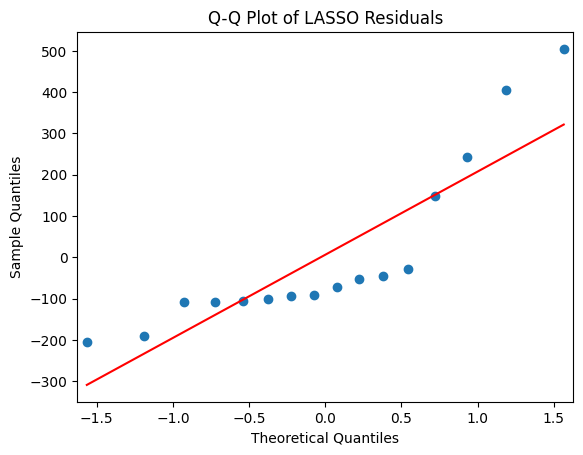

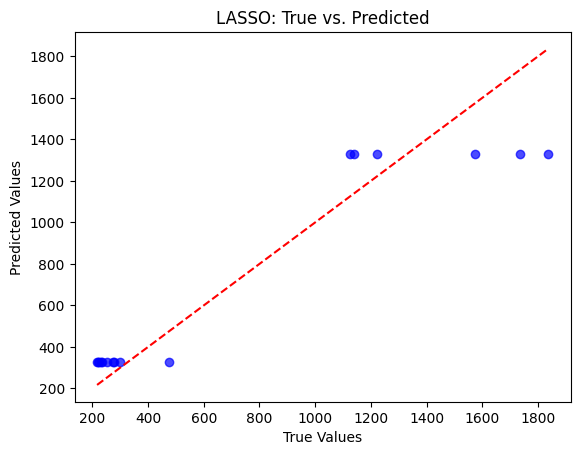

MAE: 0.851
Config: 5.2
=== RIDGE Regression ===
Coefficients: [ -7.4573726  496.51348663 -46.38633171 -53.78630415]
Intercept: 860.766129032258
R^2 on Test: 0.854
MSE on Test: 51777.066


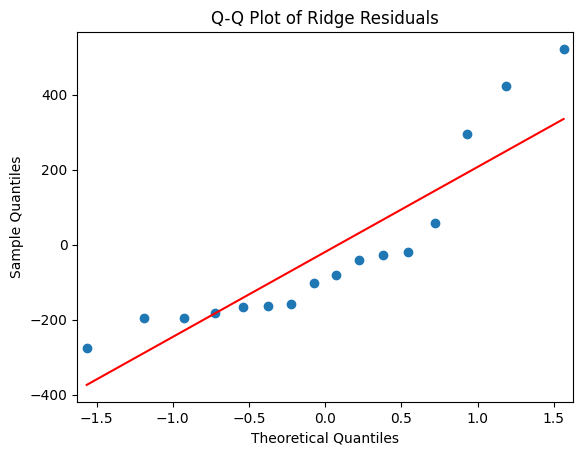

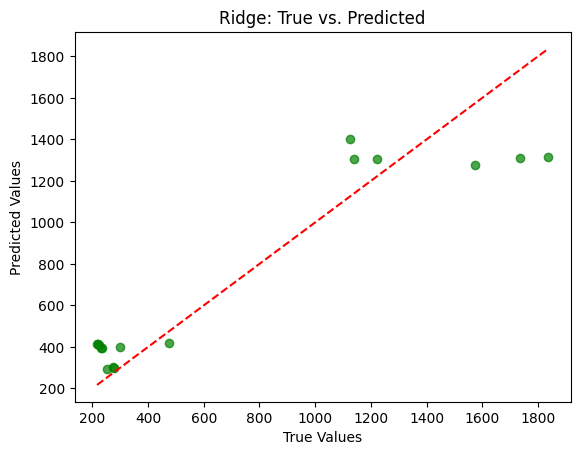

In [27]:
import pandas as pd
import numpy as np
from numpy import arange
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler


def main():
    data_dict = {
        'Volume_Fraction': [0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7],
        '1mm_Holes':       [475.2,468, 219.4, 217.2, 222, 225.3, 217.1, 293.1, 354.8, 298.1, 302.6, 231.4, 234.5],
        '1mm_MatA':        [367.1,347.3,231.8,228.3,221.7,244.3,243.9,233,273.6,318.7,279.3,272.1,313.4],
        '1mm_MatB':        [250.5,251.6,251.4,248.8,257.8,249.6,251.6,253,261.1,280.3,291.7,294.3,314.6],
        '5mm_Holes':       [2376,2340,1097,1086,1110,1126,1086,1466,1744,1490, 1513 ,1157, 1173],
        '5mm_MatA':        [1836,1736,1159,1141,1109,1222,1219,1165,1368,1594,1397,1360,1567],
        '5mm_MatB':        [1252,1258,1257,1244,1289,1248,1258,1265,1306,1402,1458,1472,1573]
    }

    # Convert to a DataFrame (wide format)
    df_wide = pd.DataFrame(data_dict)
    # CONVERT WIDE DATA TO LONG FORMAT
    rows = []
    for i in range(len(df_wide)):
        vf = df_wide.loc[i, 'Volume_Fraction']

        # 1 mm
        rows.append({
            'Volume_Fraction': vf,
            'Displacement': 1,
            'Material': 'Holes',
            'Max_Stress': df_wide.loc[i, '1mm_Holes']
        })
        rows.append({
            'Volume_Fraction': vf,
            'Displacement': 1,
            'Material': 'MatA',
            'Max_Stress': df_wide.loc[i, '1mm_MatA']
        })
        rows.append({
            'Volume_Fraction': vf,
            'Displacement': 1,
            'Material': 'MatB',
            'Max_Stress': df_wide.loc[i, '1mm_MatB']
        })

        # 5 mm
        rows.append({
            'Volume_Fraction': vf,
            'Displacement': 5,
            'Material': 'Holes',
            'Max_Stress': df_wide.loc[i, '5mm_Holes']
        })
        rows.append({
            'Volume_Fraction': vf,
            'Displacement': 5,
            'Material': 'MatA',
            'Max_Stress': df_wide.loc[i, '5mm_MatA']
        })
        rows.append({
            'Volume_Fraction': vf,
            'Displacement': 5,
            'Material': 'MatB',
            'Max_Stress': df_wide.loc[i, '5mm_MatB']
        })

    df_long = pd.DataFrame(rows)

    df_encoded = pd.get_dummies(df_long, columns=['Displacement','Material'], drop_first=True)

    X = df_encoded.drop(columns=['Max_Stress'])
    y = df_encoded['Max_Stress']

    X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
    )
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # define model evaluation method
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    # define grid
    grid = dict()
    grid['alpha'] = arange(0, 100, 0.1)
    # define search
    lasso = Lasso(random_state=42)
    lasso_cv = GridSearchCV(lasso, grid, scoring='r2', cv=cv, n_jobs=-1)
    # perform the search
    lasso_cv.fit(X_train, y_train)
    # summarize
    print('MAE: %.3f' % lasso_cv.best_score_)
    print('Config: %s' % lasso_cv.best_params_['alpha'])

    best_lasso = lasso_cv.best_estimator_
    y_pred_lasso = best_lasso.predict(X_test)
    r2_lasso = r2_score(y_test, y_pred_lasso)
    mse_lasso = mean_squared_error(y_test, y_pred_lasso)

    print("=== LASSO Regression ===")
    print("Coefficients:", best_lasso.coef_)
    print("Intercept:", best_lasso.intercept_)
    print(f"R^2 on Test: {r2_lasso:.3f}")
    print(f"MSE on Test: {mse_lasso:.3f}\n")

    # Q-Q plot for LASSO residuals
    residuals_lasso = y_test - y_pred_lasso
    sm.qqplot(residuals_lasso, line='s')
    plt.title("Q-Q Plot of LASSO Residuals")
    plt.show()

    plt.figure()
    plt.scatter(y_test, y_pred_lasso, color='blue', alpha=0.7)
    # Plot the line y = x for reference
    min_val = min(min(y_test), min(y_pred_lasso))
    max_val = max(max(y_test), max(y_pred_lasso))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title('LASSO: True vs. Predicted')
    plt.show()



    #-----------------------------------------
    #RIDGE REGRESSION
    #-----------------------------------------

    # define model evaluation method
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    # define grid
    grid = dict()
    grid['alpha'] = arange(0, 20, 0.1)
    # define search
    ridge = Ridge(random_state=42)
    ridge_cv = GridSearchCV(ridge, grid, scoring='r2', cv=cv, n_jobs=-1)
    # perform the search
    ridge_cv.fit(X_train, y_train)
    # summarize
    print('MAE: %.3f' % ridge_cv.best_score_)
    print('Config: %s' % ridge_cv.best_params_['alpha'])

    best_ridge = ridge_cv.best_estimator_
    y_pred_ridge = best_ridge.predict(X_test)
    r2_ridge = r2_score(y_test, y_pred_ridge)
    mse_ridge = mean_squared_error(y_test, y_pred_ridge)

    print("=== RIDGE Regression ===")
    print("Coefficients:", best_ridge.coef_)
    print("Intercept:", best_ridge.intercept_)
    print(f"R^2 on Test: {r2_ridge:.3f}")
    print(f"MSE on Test: {mse_ridge:.3f}")

    # Q-Q plot for Ridge residuals
    residuals_ridge = y_test - y_pred_ridge
    sm.qqplot(residuals_ridge, line='s')
    plt.title("Q-Q Plot of Ridge Residuals")
    plt.show()

    plt.figure()
    plt.scatter(y_test, y_pred_ridge, color='green', alpha=0.7)
    # Plot the line y = x for reference
    min_val = min(min(y_test), min(y_pred_ridge))
    max_val = max(max(y_test), max(y_pred_ridge))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title('Ridge: True vs. Predicted')
    plt.show()

if __name__ == "__main__":
    main()


# Max Displacement

MAE: 0.534
Config: 0.4
=== LASSO Regression ===
Coefficients: [-0.729913   -1.76219869  0.16313456  0.71630071]
Intercept: -3.270696774193548
R^2 on Test: 0.488
MSE on Test: 1.033



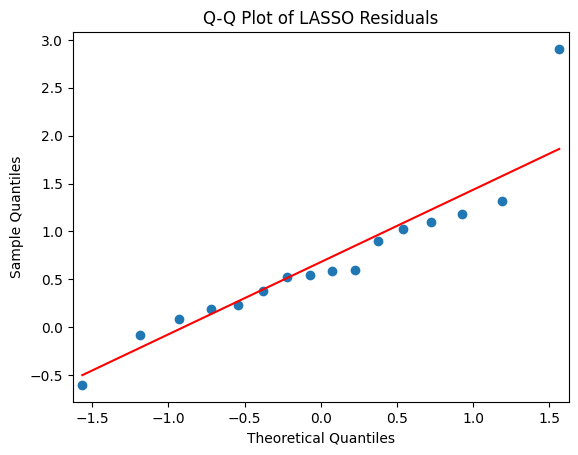

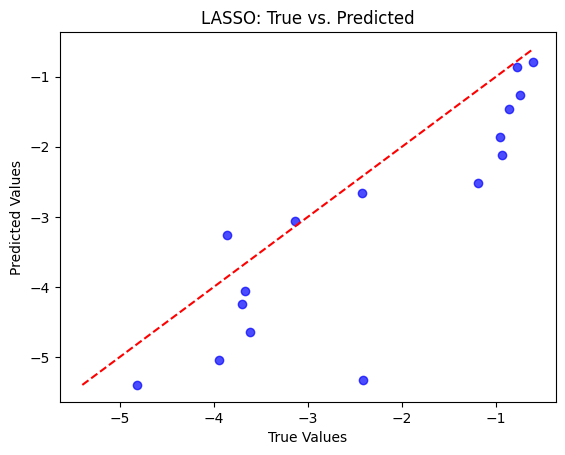

MAE: 0.534
Config: 24.5
=== RIDGE Regression ===
Coefficients: [-0.8307407  -1.50694479  0.51957298  0.94429646]
Intercept: -3.2706967741935484
R^2 on Test: 0.394
MSE on Test: 1.221


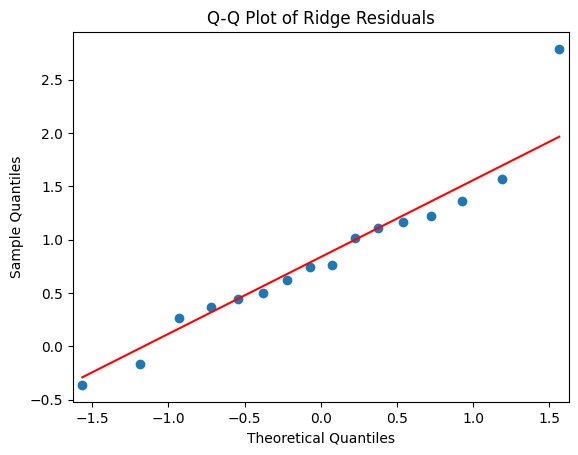

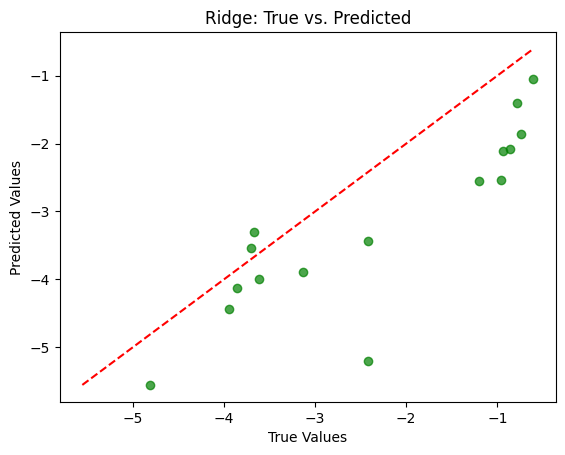

In [28]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import statsmodels.api as sm

def main():
    data_dict = {
'Volume_Fraction': [
0.1, 0.15, 0.2, 0.25, 0.3,
0.35, 0.4, 0.45, 0.5, 0.55,
0.6, 0.65, 0.7
],
'disp_100N_Holes': [
-0.7816, -0.7948, -0.7441, -0.8619, -0.8452,
-0.9624, -1.01, -1.176, -1.623, -2.424,
-1.943, -3.136, -3.861
],
'disp_100N_MatA': [
-0.7341, -0.7405, -0.7014, -0.7235, -0.767,
-0.7894, -0.7915, -0.8234, -0.9349, -1.173,
-1.196, -1.348, -1.5
],
'disp_100N_MatB': [
-0.641, -0.6385, -0.6458, -0.6443, -0.6308,
-0.6198, -0.6177, -0.6059, -0.5888, -0.5521,
-0.5255, -0.5031, -0.483
],
'disp_500N_Holes': [
-3.908, -3.974, -3.721, -4.309, -4.226,
-4.812, -5.051, -5.881, -8.114, -12.12,
-9.714, -15.68, -19.3
],
'disp_500N_MatA': [
-3.67, -3.702, -3.507, -3.617, -3.835,
-3.947, -3.958, -4.117, -4.675, -5.867,
-5.98, -6.738, -7.499
],
'disp_500N_MatB': [
-3.205, -3.192, -3.229, -3.222, -3.154,
-3.099, -3.058, -3.029, -2.944, -2.76,
-2.628, -2.515, -2.415
]
}

    # Create a wide-format DataFrame
    df_wide = pd.DataFrame(data_dict)

    # CONVERT WIDE DATA TO LONG FORMAT
    rows = []
    for i in range(len(df_wide)):
        vf = df_wide.loc[i, 'Volume_Fraction']

        # For 100N load, assign Load = 100
        rows.append({
            'Volume_Fraction': vf,
            'Load': 100,
            'Material': 'Holes',
            'Displacement': df_wide.loc[i, 'disp_100N_Holes']
        })
        rows.append({
            'Volume_Fraction': vf,
            'Load': 100,
            'Material': 'MatA',
            'Displacement': df_wide.loc[i, 'disp_100N_MatA']
        })
        rows.append({
            'Volume_Fraction': vf,
            'Load': 100,
            'Material': 'MatB',
            'Displacement': df_wide.loc[i, 'disp_100N_MatB']
        })

        # For 500N load, assign Load = 500
        rows.append({
            'Volume_Fraction': vf,
            'Load': 500,
            'Material': 'Holes',
            'Displacement': df_wide.loc[i, 'disp_500N_Holes']
        })
        rows.append({
            'Volume_Fraction': vf,
            'Load': 500,
            'Material': 'MatA',
            'Displacement': df_wide.loc[i, 'disp_500N_MatA']
        })
        rows.append({
            'Volume_Fraction': vf,
            'Load': 500,
            'Material': 'MatB',
            'Displacement': df_wide.loc[i, 'disp_500N_MatB']
        })

    df_long = pd.DataFrame(rows)

    df_encoded = pd.get_dummies(df_long, columns=['Material'], drop_first=True)

    X = df_encoded.drop(columns=['Displacement'])
    y = df_encoded['Displacement']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    scaler = StandardScaler()

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # define model evaluation method
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    # define grid
    grid = dict()
    grid['alpha'] = arange(0, 50, 0.1)
    # define search
    lasso = Lasso(random_state=42)
    lasso_cv = GridSearchCV(lasso, grid, scoring='r2', cv=cv, n_jobs=-1)
    # perform the search
    lasso_cv.fit(X_train, y_train)
    # summarize
    print('MAE: %.3f' % lasso_cv.best_score_)
    print('Config: %s' % lasso_cv.best_params_['alpha'])

    best_lasso = lasso_cv.best_estimator_
    y_pred_lasso = best_lasso.predict(X_test)
    r2_lasso = r2_score(y_test, y_pred_lasso)
    mse_lasso = mean_squared_error(y_test, y_pred_lasso)

    print("=== LASSO Regression ===")
    print("Coefficients:", best_lasso.coef_)
    print("Intercept:", best_lasso.intercept_)
    print(f"R^2 on Test: {r2_lasso:.3f}")
    print(f"MSE on Test: {mse_lasso:.3f}\n")

    # Q-Q plot for LASSO residuals
    residuals_lasso = y_test - y_pred_lasso
    sm.qqplot(residuals_lasso, line='s')
    plt.title("Q-Q Plot of LASSO Residuals")
    plt.show()

    plt.figure()
    plt.scatter(y_test, y_pred_lasso, color='blue', alpha=0.7)
    # Plot the line y = x for reference
    min_val = min(min(y_test), min(y_pred_lasso))
    max_val = max(max(y_test), max(y_pred_lasso))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title('LASSO: True vs. Predicted')
    plt.show()

    # define model evaluation method
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    # define grid
    grid = dict()
    grid['alpha'] = arange(0, 50, 0.1)
    # define search
    ridge = Ridge(random_state=42)
    ridge_cv = GridSearchCV(ridge, grid, scoring='r2', cv=cv, n_jobs=-1)
    # perform the search
    ridge_cv.fit(X_train, y_train)
    # summarize
    print('MAE: %.3f' % ridge_cv.best_score_)
    print('Config: %s' % ridge_cv.best_params_['alpha'])

    best_ridge = ridge_cv.best_estimator_
    y_pred_ridge = best_ridge.predict(X_test)
    r2_ridge = r2_score(y_test, y_pred_ridge)
    mse_ridge = mean_squared_error(y_test, y_pred_ridge)

    print("=== RIDGE Regression ===")
    print("Coefficients:", best_ridge.coef_)
    print("Intercept:", best_ridge.intercept_)
    print(f"R^2 on Test: {r2_ridge:.3f}")
    print(f"MSE on Test: {mse_ridge:.3f}")

    # Q-Q plot for Ridge residuals
    residuals_ridge = y_test - y_pred_ridge
    sm.qqplot(residuals_ridge, line='s')
    plt.title("Q-Q Plot of Ridge Residuals")
    plt.show()

    plt.figure()
    plt.scatter(y_test, y_pred_ridge, color='green', alpha=0.7)
    # Plot the line y = x for reference
    min_val = min(min(y_test), min(y_pred_ridge))
    max_val = max(max(y_test), max(y_pred_ridge))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title('Ridge: True vs. Predicted')
    plt.show()


if __name__ == "__main__":
    main()


# Max Displacement(without outliers)



MAE: 0.383
Config: 0.2
=== LASSO Regression ===
Coefficients: [-2.92209058e-01 -1.54915695e+00  1.20932315e-03  3.03077087e-01]
Intercept: -2.5491903846153843
R^2 on Test: 0.641
MSE on Test: 2.150



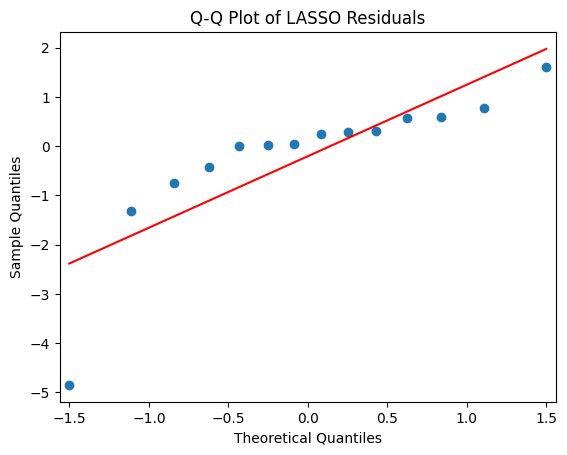

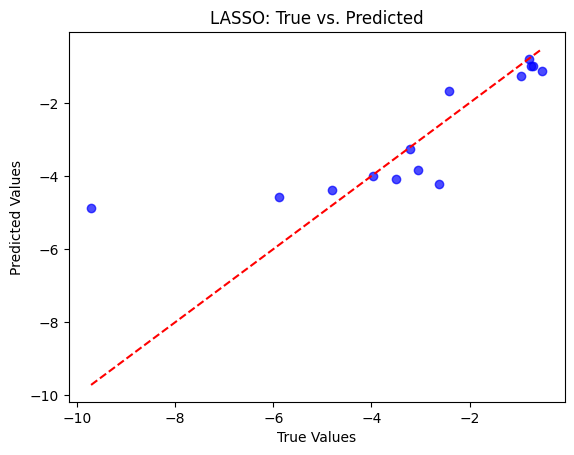

MAE: 0.200
Config: 2.1
=== RIDGE Regression ===
Coefficients: [-0.47333206 -1.67695079  0.42864227  0.69853764]
Intercept: -2.5491903846153843
R^2 on Test: 0.756
MSE on Test: 1.463


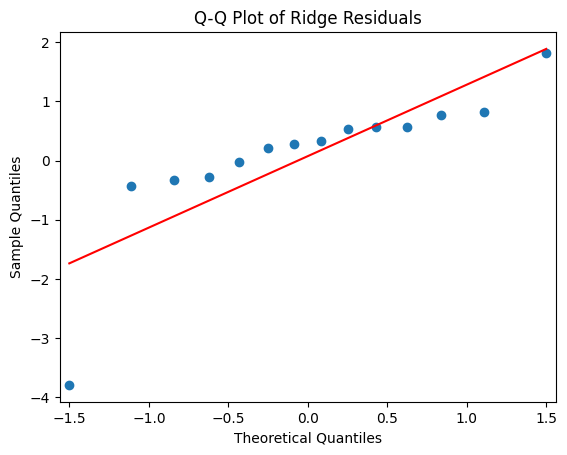

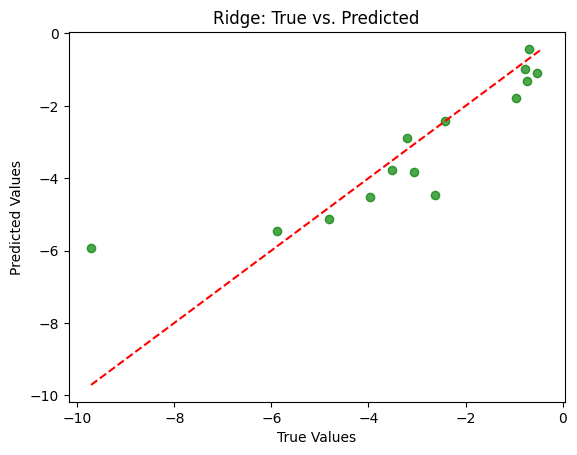

In [29]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import statsmodels.api as sm

def main():
    data_dict = {
'Volume_Fraction': [
0.1, 0.15, 0.2, 0.25, 0.3,
0.35, 0.4, 0.45, 0.5, 0.55,
0.6
],
'disp_100N_Holes': [
-0.7816, -0.7948, -0.7441, -0.8619, -0.8452,
-0.9624, -1.01, -1.176, -1.623, -2.424,
-1.943
],
'disp_100N_MatA': [
-0.7341, -0.7405, -0.7014, -0.7235, -0.767,
-0.7894, -0.7915, -0.8234, -0.9349, -1.173,
-1.196
],
'disp_100N_MatB': [
-0.641, -0.6385, -0.6458, -0.6443, -0.6308,
-0.6198, -0.6177, -0.6059, -0.5888, -0.5521,
-0.5255
],
'disp_500N_Holes': [
-3.908, -3.974, -3.721, -4.309, -4.226,
-4.812, -5.051, -5.881, -8.114, -12.12,
-9.714
],
'disp_500N_MatA': [
-3.67, -3.702, -3.507, -3.617, -3.835,
-3.947, -3.958, -4.117, -4.675, -5.867,
-5.98
],
'disp_500N_MatB': [
-3.205, -3.192, -3.229, -3.222, -3.154,
-3.099, -3.058, -3.029, -2.944, -2.76,
-2.628
]
}

    # Create a wide-format DataFrame
    df_wide = pd.DataFrame(data_dict)

    # CONVERT WIDE DATA TO LONG FORMAT
    rows = []
    for i in range(len(df_wide)):
        vf = df_wide.loc[i, 'Volume_Fraction']

        # For 100N load, assign Load = 100
        rows.append({
            'Volume_Fraction': vf,
            'Load': 100,
            'Material': 'Holes',
            'Displacement': df_wide.loc[i, 'disp_100N_Holes']
        })
        rows.append({
            'Volume_Fraction': vf,
            'Load': 100,
            'Material': 'MatA',
            'Displacement': df_wide.loc[i, 'disp_100N_MatA']
        })
        rows.append({
            'Volume_Fraction': vf,
            'Load': 100,
            'Material': 'MatB',
            'Displacement': df_wide.loc[i, 'disp_100N_MatB']
        })

        # For 500N load, assign Load = 500
        rows.append({
            'Volume_Fraction': vf,
            'Load': 500,
            'Material': 'Holes',
            'Displacement': df_wide.loc[i, 'disp_500N_Holes']
        })
        rows.append({
            'Volume_Fraction': vf,
            'Load': 500,
            'Material': 'MatA',
            'Displacement': df_wide.loc[i, 'disp_500N_MatA']
        })
        rows.append({
            'Volume_Fraction': vf,
            'Load': 500,
            'Material': 'MatB',
            'Displacement': df_wide.loc[i, 'disp_500N_MatB']
        })

    df_long = pd.DataFrame(rows)

    df_encoded = pd.get_dummies(df_long, columns=['Material'], drop_first=True)

    X = df_encoded.drop(columns=['Displacement'])
    y = df_encoded['Displacement']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    scaler = StandardScaler()

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # define model evaluation method
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    # define grid
    grid = dict()
    grid['alpha'] = arange(0, 50, 0.1)
    # define search
    lasso = Lasso(random_state=42)
    lasso_cv = GridSearchCV(lasso, grid, scoring='r2', cv=cv, n_jobs=-1)
    # perform the search
    lasso_cv.fit(X_train, y_train)
    # summarize
    print('MAE: %.3f' % lasso_cv.best_score_)
    print('Config: %s' % lasso_cv.best_params_['alpha'])

    best_lasso = lasso_cv.best_estimator_
    y_pred_lasso = best_lasso.predict(X_test)
    r2_lasso = r2_score(y_test, y_pred_lasso)
    mse_lasso = mean_squared_error(y_test, y_pred_lasso)

    print("=== LASSO Regression ===")
    print("Coefficients:", best_lasso.coef_)
    print("Intercept:", best_lasso.intercept_)
    print(f"R^2 on Test: {r2_lasso:.3f}")
    print(f"MSE on Test: {mse_lasso:.3f}\n")

    # Q-Q plot for LASSO residuals
    residuals_lasso = y_test - y_pred_lasso
    sm.qqplot(residuals_lasso, line='s')
    plt.title("Q-Q Plot of LASSO Residuals")
    plt.show()

    plt.figure()
    plt.scatter(y_test, y_pred_lasso, color='blue', alpha=0.7)
    # Plot the line y = x for reference
    min_val = min(min(y_test), min(y_pred_lasso))
    max_val = max(max(y_test), max(y_pred_lasso))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title('LASSO: True vs. Predicted')
    plt.show()

    # define model evaluation method
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    # define grid
    grid = dict()
    grid['alpha'] = arange(0, 50, 0.1)
    # define search
    ridge = Ridge(random_state=42)
    ridge_cv = GridSearchCV(ridge, grid, scoring='r2', cv=cv, n_jobs=-1)
    # perform the search
    ridge_cv.fit(X_train, y_train)
    # summarize
    print('MAE: %.3f' % ridge_cv.best_score_)
    print('Config: %s' % ridge_cv.best_params_['alpha'])

    best_ridge = ridge_cv.best_estimator_
    y_pred_ridge = best_ridge.predict(X_test)
    r2_ridge = r2_score(y_test, y_pred_ridge)
    mse_ridge = mean_squared_error(y_test, y_pred_ridge)

    print("=== RIDGE Regression ===")
    print("Coefficients:", best_ridge.coef_)
    print("Intercept:", best_ridge.intercept_)
    print(f"R^2 on Test: {r2_ridge:.3f}")
    print(f"MSE on Test: {mse_ridge:.3f}")

    # Q-Q plot for Ridge residuals
    residuals_ridge = y_test - y_pred_ridge
    sm.qqplot(residuals_ridge, line='s')
    plt.title("Q-Q Plot of Ridge Residuals")
    plt.show()

    plt.figure()
    plt.scatter(y_test, y_pred_ridge, color='green', alpha=0.7)
    # Plot the line y = x for reference
    min_val = min(min(y_test), min(y_pred_ridge))
    max_val = max(max(y_test), max(y_pred_ridge))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title('Ridge: True vs. Predicted')
    plt.show()


if __name__ == "__main__":
    main()


# My Data


Best alpha for LASSO (ΔK): 0.02
LASSO (ΔK) -- MSE: 22.947903618680225
LASSO (ΔK) -- R^2: 0.3952884276213181
LASSO (ΔK) -- Coefficients: [-0.03073443 -8.93100741  0.        ]
LASSO (ΔK) -- Intercept: 19.425258641776573 



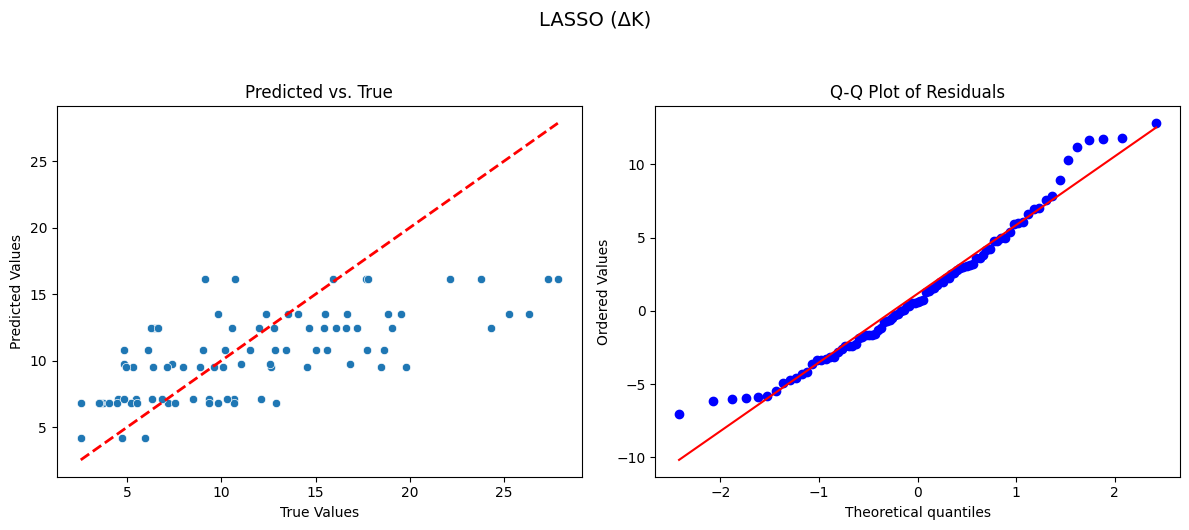

Best alpha for Ridge (ΔK): 1.03
Ridge (ΔK) -- MSE: 22.964537588162433
Ridge (ΔK) -- R^2: 0.39485009765411805
Ridge (ΔK) -- Coefficients: [-0.03074899 -8.82189231  0.        ]
Ridge (ΔK) -- Intercept: 19.38381943096782 



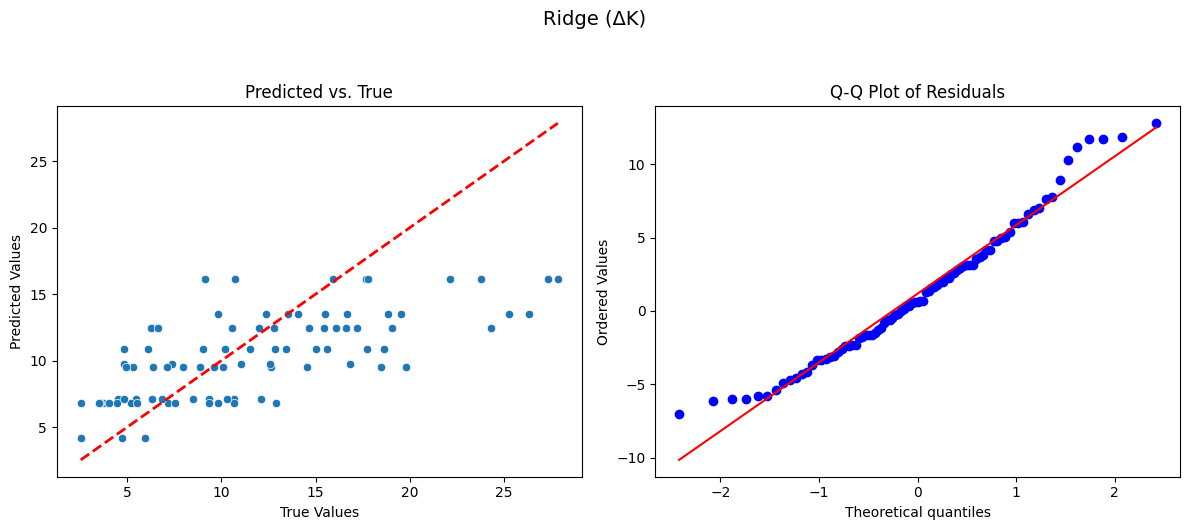

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.951e-14, tolerance: 1.727e-17 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent

Best alpha for LASSO (da/dN): 0.0
LASSO (da/dN) -- MSE: 5.041124660274935e-16
LASSO (da/dN) -- R^2: 0.07146789043542778
LASSO (da/dN) -- Coefficients: [-5.14423013e-12 -2.68677181e-08  0.00000000e+00]
LASSO (da/dN) -- Intercept: 2.234198472006579e-08 



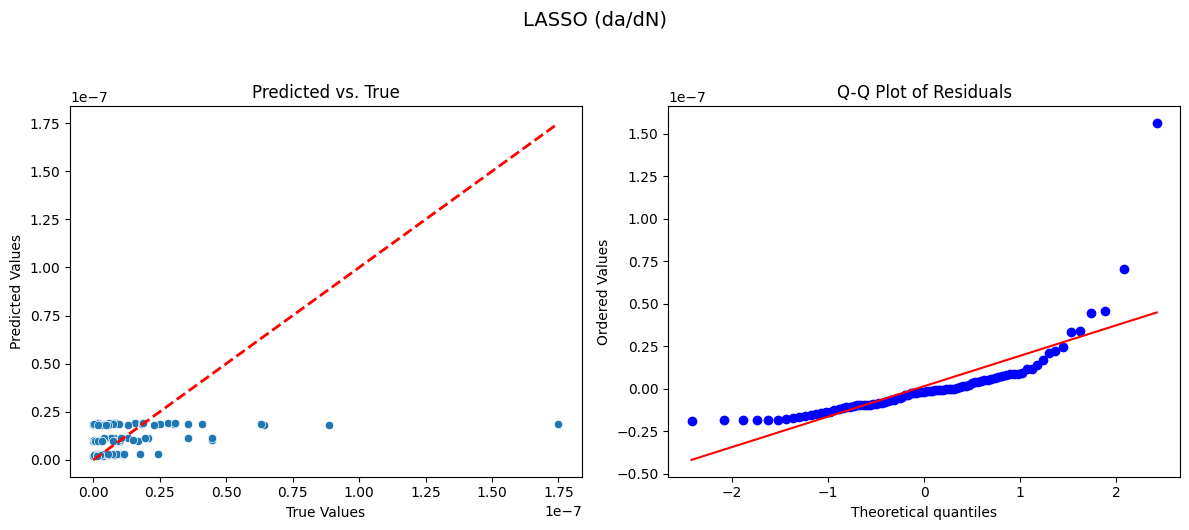

Best alpha for Ridge (da/dN): 4.48
Ridge (da/dN) -- MSE: 5.05958725243813e-16
Ridge (da/dN) -- R^2: 0.06806723863555997
Ridge (da/dN) -- Coefficients: [-5.71714478e-12 -2.16890609e-08  0.00000000e+00]
Ridge (da/dN) -- Intercept: 2.035211952747596e-08 



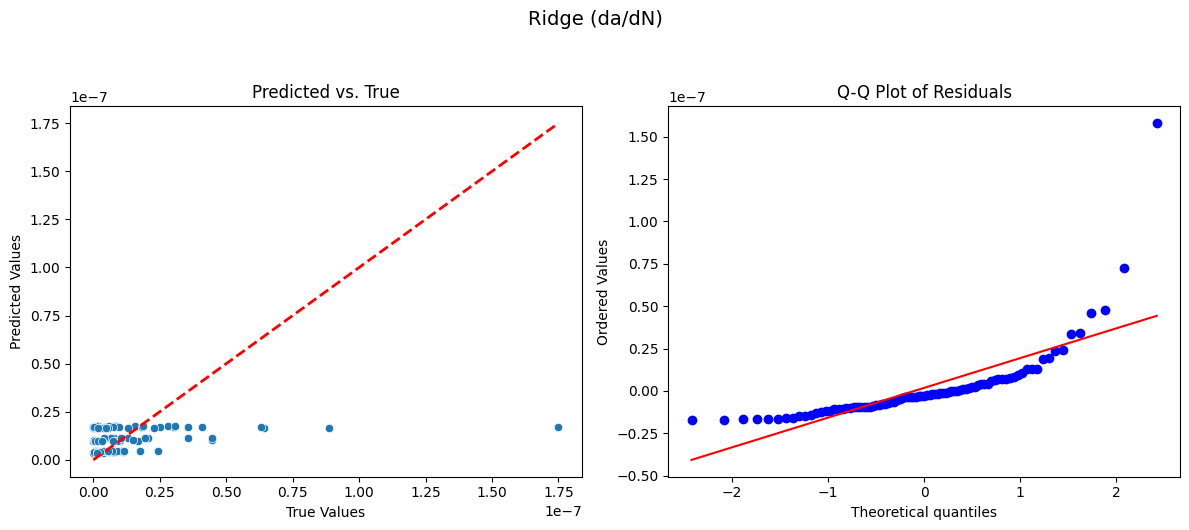

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


def plot_predictions_and_qq(y_true, y_pred, title_prefix):
    """
    Creates a 1x2 subplot:
      1) y_pred vs y_true scatter with y=x line
      2) Q-Q plot of the residuals
    """
    residuals = y_true - y_pred

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(title_prefix, fontsize=14, y=1.05)

    # 1) Predictions vs. True
    ax1 = axes[0]
    sns.scatterplot(x=y_true, y=y_pred, ax=ax1)
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    ax1.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
    ax1.set_xlabel('True Values')
    ax1.set_ylabel('Predicted Values')
    ax1.set_title('Predicted vs. True')

    # 2) Q-Q plot of residuals
    ax2 = axes[1]
    stats.probplot(residuals, dist="norm", plot=ax2)
    ax2.set_title("Q-Q Plot of Residuals")

    plt.tight_layout()
    plt.show()
np.random.seed(42)
df = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/prelassodata.csv")


# Independent variables
X = df[['Temperature', 'LoadRatio', 'Frequency']]

# Response variables
y_dK = df['DeltaK']      # Stress intensity range (ΔK)
y_da = np.log1p(df['da_dN'])       # Crack growth rate (da/dN)

X_train_dK, X_test_dK, y_train_dK, y_test_dK = train_test_split(
    X, y_dK, test_size=0.2, random_state=42
)

X_train_da, X_test_da, y_train_da, y_test_da = train_test_split(
    X, y_da, test_size=0.2, random_state=42
)


#LASSO Regression for ΔK
lasso_params = {'alpha': arange(0, 10, 0.01)}
lasso_grid_dK = GridSearchCV(
    Lasso(random_state=42),
    param_grid=lasso_params,
    cv=5,
    scoring='r2',
    n_jobs=-1
)
lasso_grid_dK.fit(X_train_dK, y_train_dK)

best_lasso_dK = lasso_grid_dK.best_estimator_
print("Best alpha for LASSO (ΔK):", lasso_grid_dK.best_params_['alpha'])

# Predictions & metrics
y_pred_lasso_dK = best_lasso_dK.predict(X_test_dK)
mse_lasso_dK = mean_squared_error(y_test_dK, y_pred_lasso_dK)
r2_lasso_dK = r2_score(y_test_dK, y_pred_lasso_dK)

print("LASSO (ΔK) -- MSE:", mse_lasso_dK)
print("LASSO (ΔK) -- R^2:", r2_lasso_dK)
print("LASSO (ΔK) -- Coefficients:", best_lasso_dK.coef_)
print("LASSO (ΔK) -- Intercept:", best_lasso_dK.intercept_, "\n")

plot_predictions_and_qq(y_test_dK, y_pred_lasso_dK, title_prefix="LASSO (ΔK)")

# Ridge Regression for ΔK
ridge_params = {'alpha': arange(0, 10, 0.01)}
ridge_grid_dK = GridSearchCV(
    Ridge(random_state=42),
    param_grid=ridge_params,
    cv=5,
    scoring='r2',
    n_jobs=-1
)
ridge_grid_dK.fit(X_train_dK, y_train_dK)

best_ridge_dK = ridge_grid_dK.best_estimator_
print("Best alpha for Ridge (ΔK):", ridge_grid_dK.best_params_['alpha'])

y_pred_ridge_dK = best_ridge_dK.predict(X_test_dK)
mse_ridge_dK = mean_squared_error(y_test_dK, y_pred_ridge_dK)
r2_ridge_dK = r2_score(y_test_dK, y_pred_ridge_dK)

print("Ridge (ΔK) -- MSE:", mse_ridge_dK)
print("Ridge (ΔK) -- R^2:", r2_ridge_dK)
print("Ridge (ΔK) -- Coefficients:", best_ridge_dK.coef_)
print("Ridge (ΔK) -- Intercept:", best_ridge_dK.intercept_, "\n")

plot_predictions_and_qq(y_test_dK, y_pred_ridge_dK, title_prefix="Ridge (ΔK)")


#LASSO Regression for da/dN
lasso_grid_da = GridSearchCV(
    Lasso(random_state=42),
    param_grid=lasso_params,  # reuse the same lasso_params
    cv=5,
    scoring='r2',
    n_jobs=-1
)
lasso_grid_da.fit(X_train_da, y_train_da)

best_lasso_da = lasso_grid_da.best_estimator_
print("Best alpha for LASSO (da/dN):", lasso_grid_da.best_params_['alpha'])

y_pred_lasso_da = best_lasso_da.predict(X_test_da)
mse_lasso_da = mean_squared_error(y_test_da, y_pred_lasso_da)
r2_lasso_da = r2_score(y_test_da, y_pred_lasso_da)

print("LASSO (da/dN) -- MSE:", mse_lasso_da)
print("LASSO (da/dN) -- R^2:", r2_lasso_da)
print("LASSO (da/dN) -- Coefficients:", best_lasso_da.coef_)
print("LASSO (da/dN) -- Intercept:", best_lasso_da.intercept_, "\n")

plot_predictions_and_qq(y_test_da, y_pred_lasso_da, title_prefix="LASSO (da/dN)")

#Ridge Regression for da/dN
ridge_grid_da = GridSearchCV(
    Ridge(random_state=42),
    param_grid=ridge_params,  # reuse the same ridge_params
    cv=5,
    scoring='r2',
    n_jobs=-1
)
ridge_grid_da.fit(X_train_da, y_train_da)

best_ridge_da = ridge_grid_da.best_estimator_
print("Best alpha for Ridge (da/dN):", ridge_grid_da.best_params_['alpha'])

y_pred_ridge_da = best_ridge_da.predict(X_test_da)
mse_ridge_da = mean_squared_error(y_test_da, y_pred_ridge_da)
r2_ridge_da = r2_score(y_test_da, y_pred_ridge_da)

print("Ridge (da/dN) -- MSE:", mse_ridge_da)
print("Ridge (da/dN) -- R^2:", r2_ridge_da)
print("Ridge (da/dN) -- Coefficients:", best_ridge_da.coef_)
print("Ridge (da/dN) -- Intercept:", best_ridge_da.intercept_, "\n")

plot_predictions_and_qq(y_test_da, y_pred_ridge_da, title_prefix="Ridge (da/dN)")

